In [77]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

(13, 215)


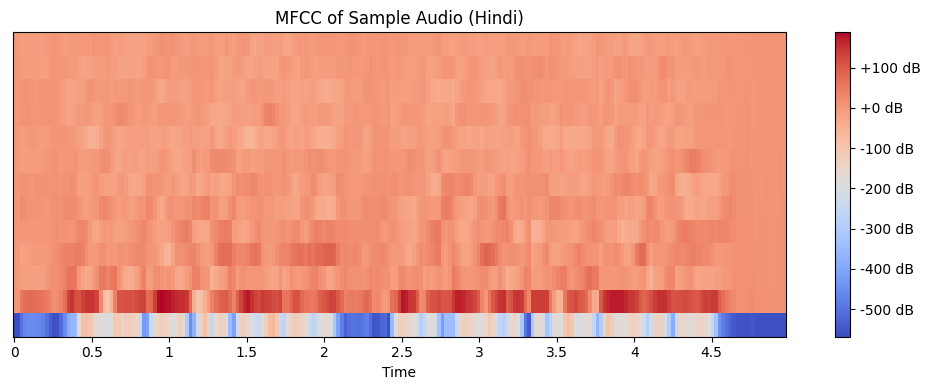

In [61]:
sample_file = "/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Hindi/0.mp3"


y, sr = librosa.load(sample_file)

# Extract MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

print(mfcc.shape)

# Visualize
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC of Sample Audio (Hindi)')
plt.tight_layout()
plt.show()

In [62]:
base_path = "/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset"

In [80]:
languages = ['Hindi', 'Bengali']

x = []
y = []

n_mfcc = 13
max_len = 215

for lang in languages:
    lang_path = os.path.join(base_path, lang)
    for file in os.listdir(lang_path)[:5000]:
        file_path = os.path.join(lang_path, file)
        try:
            audio, sr = librosa.load(file_path)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

            if mfcc.shape[1] < max_len:
                pad_width = max_len - mfcc.shape[1]
                mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :max_len]

            x.append(mfcc)
            y.append(lang)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")


x = np.array(x)
y = np.array(y)

print(f"✅ Feature shape: {x.shape}, Labels shape: {y.shape}")

✅ Feature shape: (10000, 13, 215), Labels shape: (10000,)


In [75]:
# languages = ['Bengali', 'Hindi', 'Malayalam', 'Punjabi', 'Telugu',
#              'Gujarati', 'Kannada', 'Marathi', 'Tamil', 'Urdu']

In [76]:
count = {}
for lang in languages:
    count[lang] = 0
    lang_path = os.path.join(base_path, lang)
    for file in os.listdir(lang_path):
        count[lang] = count[lang] + 1

print(count)

{'Bengali': 27258, 'Hindi': 25462, 'Malayalam': 24044, 'Punjabi': 26229, 'Telugu': 23656, 'Gujarati': 26441, 'Kannada': 22208, 'Marathi': 25379, 'Tamil': 24196, 'Urdu': 31960}


In [81]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

y_categorical = to_categorical(y_encoded)


print(f"Encoded Labels: {np.unique(y)} → {np.unique(y_encoded)}")
print(f"One-hot shape: {y_categorical.shape}")

Encoded Labels: ['Bengali' 'Hindi'] → [0 1]
One-hot shape: (10000, 2)


In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y_categorical, test_size = 0.2, random_state = 42)

In [83]:

print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_test.shape}")

Training set shape: (8000, 13, 215)
Validation set shape: (2000, 13, 215)


In [84]:
model = Sequential()

model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))


model.add(Dense(32, activation='relu'))
model.add(Dense(len(languages), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 13, 128)             │         176,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 227,682 (889.38 KB)

 Trainable params: 227,682 (889.38 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])


score = model.evaluate(x_test, y_test)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5807 - loss: 0.6689 - val_accuracy: 0.6515 - val_loss: 0.6267
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.7023 - loss: 0.5792 - val_accuracy: 0.7365 - val_loss: 0.5255
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7788 - loss: 0.4696 - val_accuracy: 0.7225 - val_loss: 0.5578
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8214 - loss: 0.3974 - val_accuracy: 0.7785 - val_loss: 0.4792
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8523 - loss: 0.3408 - val_accuracy: 0.7930 - val_loss: 0.4457
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8771 - loss: 0.2976 - val_accuracy: 0.8150 - val_loss: 0.4263
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9015 - loss: 0.2451 - val_accuracy: 0.8215 - val_loss: 0.4258
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9123 - loss: 0.2202 - val_acc

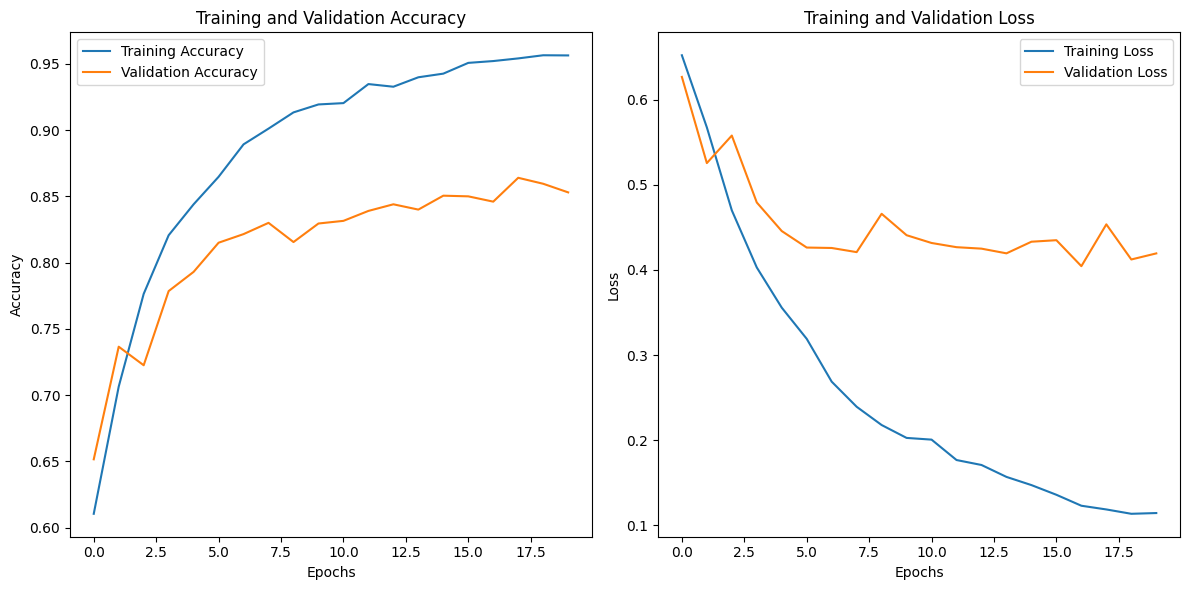

In [86]:
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()